# MSP projekt - část druhá - regrese
---
Autor: Matěj Konopík, Prosinec 2023
---
Nejdříve načteme data a pro kategorický atribut OSType provedeme one-hot encoding. Zároven převedeme výsledné dummy sloupce na celočíselný typ (0 nebo 1). Také použijeme drop_first, abysme se zbavili jednoho dummy sloupce, který je redundantní. Zde odstraníme OSType_Android.

In [22]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [23]:
data = pd.read_csv('../data/data_2.csv')

data_encoded = pd.get_dummies(data, columns=['OSType'], drop_first=True)

dummy_columns = data_encoded.filter(like='OSType_').columns
data_encoded[dummy_columns] = data_encoded[dummy_columns].astype(int)

print(data_encoded.head())

   ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]  OSType_MacOS  \
0         4113          0.8283        0.1717         47             0   
1         7549          0.3461        0.6539         46             0   
2         8855          0.2178        0.7822         55             0   
3         8870          0.0794        0.9206         56             0   
4         9559          0.7282        0.2718         76             1   

   OSType_Windows  OSType_iOS  
0               0           1  
1               0           1  
2               1           0  
3               0           0  
4               0           0  


### Kolinearita
---
Dále si vytvoříme korelační matici a následně si ji zobrazíme. Zde použijeme pouze prediktory - ActiveUsers, InteractingPct a ScrollingPct. 

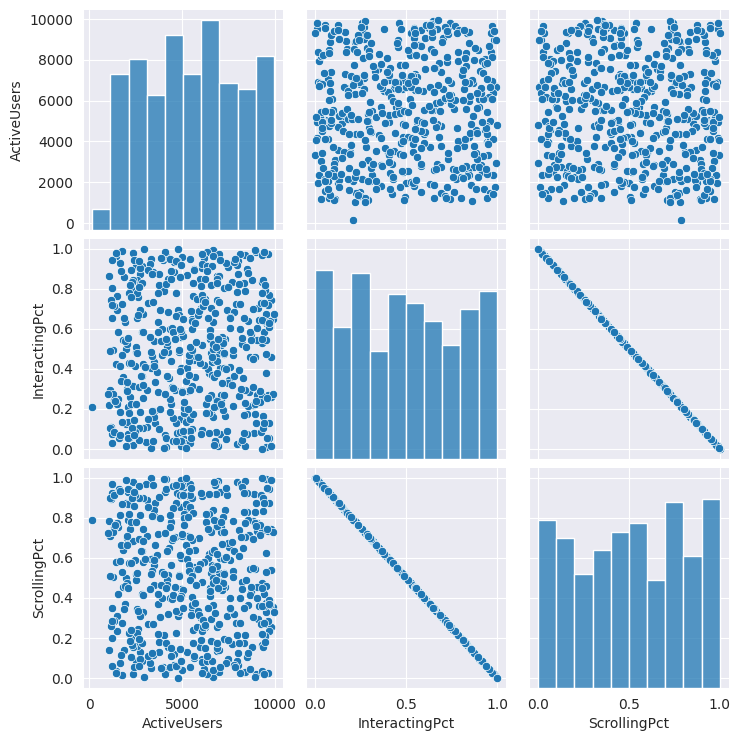

In [24]:
sns.pairplot(data[['ActiveUsers', 'InteractingPct', 'ScrollingPct']])
plt.show()
correlation_matrix = data[['ActiveUsers', 'InteractingPct', 'ScrollingPct']].corr()

V datech byla pozorována dokonalá negativní korelace (-1) mezi "InteractingPct" a "ScrollingPct" - jedná se o atributy, které jsou si doplňky. Tato situace naznačuje lineární závislost těchto dvou proměnných, což v regresní analýze může vést k problémům s multicolinearitou. Proto bylo rozhodnuto odstranit "ScrollingPct" z modelu, čímž se snižuje redundance a zvyšuje spolehlivost odhadů regresních koeficientů.

In [25]:
data_encoded.drop('ScrollingPct', axis=1, inplace=True)
print(data_encoded.head())

   ActiveUsers  InteractingPct  Ping [ms]  OSType_MacOS  OSType_Windows  \
0         4113          0.8283         47             0               0   
1         7549          0.3461         46             0               0   
2         8855          0.2178         55             0               1   
3         8870          0.0794         56             0               0   
4         9559          0.7282         76             1               0   

   OSType_iOS  
0           1  
1           1  
2           0  
3           0  
4           0  


### Vytvoření plného kvadratického modelu 


In [26]:
data_encoded['ActiveUsers^2'] = data_encoded['ActiveUsers'] ** 2
data_encoded['InteractingPct^2'] = data_encoded['InteractingPct'] ** 2

data_encoded['ActiveUsers_x_InteractingPct'] = data_encoded['ActiveUsers'] * data_encoded['InteractingPct']

data_encoded['ActiveUsers_x_MacOS'] = data_encoded['ActiveUsers'] * data_encoded['OSType_MacOS']
data_encoded['ActiveUsers_x_Windows'] = data_encoded['ActiveUsers'] * data_encoded['OSType_Windows']
data_encoded['ActiveUsers_x_iOS'] = data_encoded['ActiveUsers'] * data_encoded['OSType_iOS']

data_encoded['InteractingPct_x_MacOS'] = data_encoded['InteractingPct'] * data_encoded['OSType_MacOS']
data_encoded['InteractingPct_x_Windows'] = data_encoded['InteractingPct'] * data_encoded['OSType_Windows']
data_encoded['InteractingPct_x_iOS'] = data_encoded['InteractingPct'] * data_encoded['OSType_iOS']

print(data_encoded.head())

   ActiveUsers  InteractingPct  Ping [ms]  OSType_MacOS  OSType_Windows  \
0         4113          0.8283         47             0               0   
1         7549          0.3461         46             0               0   
2         8855          0.2178         55             0               1   
3         8870          0.0794         56             0               0   
4         9559          0.7282         76             1               0   

   OSType_iOS  ActiveUsers^2  InteractingPct^2  ActiveUsers_x_InteractingPct  \
0           1       16916769          0.686081                     3406.7979   
1           1       56987401          0.119785                     2612.7089   
2           0       78411025          0.047437                     1928.6190   
3           0       78676900          0.006304                      704.2780   
4           0       91374481          0.530275                     6960.8638   

   ActiveUsers_x_MacOS  ActiveUsers_x_Windows  ActiveUsers_x_iOS  \


### Fitting modelu se základní sadou prediktorů

In [27]:
X = data_encoded.drop('Ping [ms]', axis=1)
y = data_encoded['Ping [ms]']

X_with_constant = sm.add_constant(X)
full_model = sm.OLS(y, X_with_constant).fit()

print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        22:30:17   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Normalizace prediktorů

Nyní normalizujeme prediktory, abychom dosáhli rovnocenného přínosu všech prediktorů. Využijeme MinMaxScaler, který převede hodnoty do intervalu `[0, 1]`.

In [28]:
predictor_columns = X.columns
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=predictor_columns)
print(X_normalized.head())

   ActiveUsers  InteractingPct  OSType_MacOS  OSType_Windows  OSType_iOS  \
0     0.404082        0.829376           0.0             0.0         1.0   
1     0.754694        0.346258           0.0             0.0         1.0   
2     0.887959        0.217714           0.0             1.0         0.0   
3     0.889490        0.079050           0.0             0.0         0.0   
4     0.959796        0.729085           1.0             0.0         0.0   

   ActiveUsers^2  InteractingPct^2  ActiveUsers_x_InteractingPct  \
0       0.170573          0.688006                      0.362253   
1       0.575168          0.120121                      0.277700   
2       0.791484          0.047570                      0.204859   
3       0.794168          0.006322                      0.074494   
4       0.922377          0.531763                      0.740683   

   ActiveUsers_x_MacOS  ActiveUsers_x_Windows  ActiveUsers_x_iOS  \
0             0.000000               0.000000           0.430455  

Opět si zobrazíme summary modelu

In [29]:
X_normalized_with_constant = sm.add_constant(X_normalized)
normalized_model = sm.OLS(y, X_normalized_with_constant).fit()
print(normalized_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        22:30:17   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Zpětná eliminace
Provedem zpětnou eliminaci prediktorů, abychom získali model s lepší prediktivní schopností. Zde použijeme signifikanci 0.05.

In [30]:
def backward_elimination(data, target, significance_level = 0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:] 
        max_p_value = p_values.max()
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

selected_features = backward_elimination(X_normalized, data_encoded['Ping [ms]'])

X_selected = X_normalized[selected_features]

Opět fitneme model a zobrazíme summary

In [31]:
X_selected_with_constant = sm.add_constant(X_selected)
back_elim_model = sm.OLS(y, X_selected_with_constant).fit()
print(back_elim_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     330.9
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          9.30e-193
Time:                        22:30:17   Log-Likelihood:                -1599.7
No. Observations:                 502   AIC:                             3217.
Df Residuals:                     493   BIC:                             3255.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### VIF eliminace
Provedem analýtu VIF pomocí funkce `variance_inflation_factor` z balíčku `statsmodels.stats.outliers_influence`. Pokud bude hodnota VIF některého predikotru nad 10, tak odstraníme daný prediktor s nejvyšší hodnotou VIF.

In [32]:
vif_data = pd.DataFrame()
vif_data['feature'] = X_selected_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(X_selected_with_constant.values, i) for i in range(X_selected_with_constant.shape[1])]

vif_data

,feature,VIF
0,const,32.761712
1,ActiveUsers,24.981312
2,InteractingPct,5.576012
3,OSType_Windows,5.551936
4,ActiveUsers^2,22.204978
5,ActiveUsers_x_InteractingPct,8.566008
6,ActiveUsers_x_MacOS,1.657555
7,ActiveUsers_x_Windows,6.474746
8,ActiveUsers_x_iOS,1.550683


Vidíme, že ActiveUsers má hodnotu nejvyšší hodnotu VIF 24.29. Je jasné, že ActiveUsers a jeho kvadrát jsou silně korelované, jelikož se vlastně jedná jen o hodnotu umocněnou na druhou. Odstraníme ale ActiveUsers^2, jelikož se jedná o dobrou praxi.

In [33]:
X_selected_reduced = X_selected.drop('ActiveUsers^2', axis=1)

X_selected_reduced_with_constant = sm.add_constant(X_selected_reduced)
vif_data_cleaned = pd.DataFrame()
vif_data_cleaned['feature'] = X_selected_reduced_with_constant.columns
vif_data_cleaned['VIF'] = [variance_inflation_factor(X_selected_reduced_with_constant.values, i) for i in range(X_selected_reduced_with_constant.shape[1])]

# Display the updated VIF values
vif_data_cleaned

,feature,VIF
0,const,21.405088
1,ActiveUsers,4.567019
2,InteractingPct,5.561726
3,OSType_Windows,5.546736
4,ActiveUsers_x_InteractingPct,8.550677
5,ActiveUsers_x_MacOS,1.656643
6,ActiveUsers_x_Windows,6.464752
7,ActiveUsers_x_iOS,1.550671


Je vidět, že se všechny hodnoty VIF snížily pod 10, což by již mohlo být v pořádku.
Opět fitneme model a zobrazíme summary

In [34]:
X_selected_vif_reduced_with_constant = sm.add_constant(X_selected_reduced)
vif_elim_model = sm.OLS(y, X_selected_vif_reduced_with_constant).fit()
print(vif_elim_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     309.3
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          4.99e-176
Time:                        22:30:17   Log-Likelihood:                -1642.0
No. Observations:                 502   AIC:                             3300.
Df Residuals:                     494   BIC:                             3334.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Denormalizace

Upravíme scaler a vrátíme hodnoty do původního rozsahu.

In [35]:
selected_predictor_columns = X_selected_reduced.columns
selected_indices = [list(predictor_columns).index(col) for col in selected_predictor_columns]

denorm_scaler = MinMaxScaler()
denorm_scaler.min_ = scaler.min_[selected_indices]
denorm_scaler.scale_ = scaler.scale_[selected_indices]

X_denormalized = denorm_scaler.inverse_transform(X_selected_reduced)
X_denormalized = pd.DataFrame(X_denormalized, columns=selected_predictor_columns)

print(X_denormalized.head())

   ActiveUsers  InteractingPct  OSType_Windows  ActiveUsers_x_InteractingPct  \
0       4113.0          0.8283             0.0                     3406.7979   
1       7549.0          0.3461             0.0                     2612.7089   
2       8855.0          0.2178             1.0                     1928.6190   
3       8870.0          0.0794             0.0                      704.2780   
4       9559.0          0.7282             0.0                     6960.8638   

   ActiveUsers_x_MacOS  ActiveUsers_x_Windows  ActiveUsers_x_iOS  
0                  0.0                    0.0             4113.0  
1                  0.0                    0.0             7549.0  
2                  0.0                 8855.0                0.0  
3                  0.0                    0.0                0.0  
4               9559.0                    0.0                0.0  


Opět fitneme model a zobrazíme summary

In [36]:
X_denormalized_with_constant = sm.add_constant(X_denormalized)
denorm_model = sm.OLS(y, X_denormalized_with_constant).fit()
print(denorm_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     309.3
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          4.99e-176
Time:                        22:30:17   Log-Likelihood:                -1642.0
No. Observations:                 502   AIC:                             3300.
Df Residuals:                     494   BIC:                             3334.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Detekce a odstranění odlehlých pozorování
Z grafu reziduí níže je vidět, že existují dva odlehlé body. Ty ale můžeme dopředu zjistit z reziduí a odstranit je. Zde použijeme 3 * standardní odchylku reziduí jako hranici pro odlehlá pozorování.

In [37]:
residuals = denorm_model.resid
residuals_std = residuals.std()

outliers = np.abs(residuals) > 3 * residuals_std

outlier_indices = outliers[outliers].index
outlier_indices

Index([255, 476], dtype='int64')

Po odstranění odlehlých pozorování, majících vliv na model, ze získaných indexů, fitneme model a zobrazíme summary pro finální podobu.

In [38]:
X_cleaned = X_denormalized.drop(outlier_indices)
y_cleaned = y.drop(outlier_indices)

X_cleaned_with_constant = sm.add_constant(X_cleaned)
final_model_cleaned = sm.OLS(y_cleaned, X_cleaned_with_constant).fit()

print(final_model_cleaned.summary())
print("\n\n", X_cleaned.head(3))

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     374.2
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.71e-192
Time:                        22:30:17   Log-Likelihood:                -1592.3
No. Observations:                 500   AIC:                             3201.
Df Residuals:                     492   BIC:                             3234.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Kontrola VIF u poslední verze dat
Všechny hodnoty VIF jsou nyní pod 10, což znamená, že neexistuje příliš silná kolinearita mezi prediktory. Sloupec const, respektive konstantní složka modelu má VIF vyšší, ale toto by nemělo být u regresních modelů neobvyklé.

In [39]:
vif_data_cleaned = pd.DataFrame()
vif_data_cleaned['feature'] = X_cleaned_with_constant.columns
vif_data_cleaned['VIF'] = [variance_inflation_factor(X_cleaned_with_constant.values, i) for i in range(X_cleaned_with_constant.shape[1])]

vif_data_cleaned

,feature,VIF
0,const,22.817977
1,ActiveUsers,4.598525
2,InteractingPct,5.601527
3,OSType_Windows,5.543347
4,ActiveUsers_x_InteractingPct,8.586170
5,ActiveUsers_x_MacOS,1.654880
6,ActiveUsers_x_Windows,6.455178
7,ActiveUsers_x_iOS,1.549256


### Q-Q a resiudální grafy

Nyní se můžeme podívat na Q-Q grafy a grafy reziduí. Zde je vidět, že velmi pravděpodobně z důvodu odstranění odlehlých pozorování se grafy výrazně zlepšily. Odlehlé hodnoty měly zřejmě velký leverage.


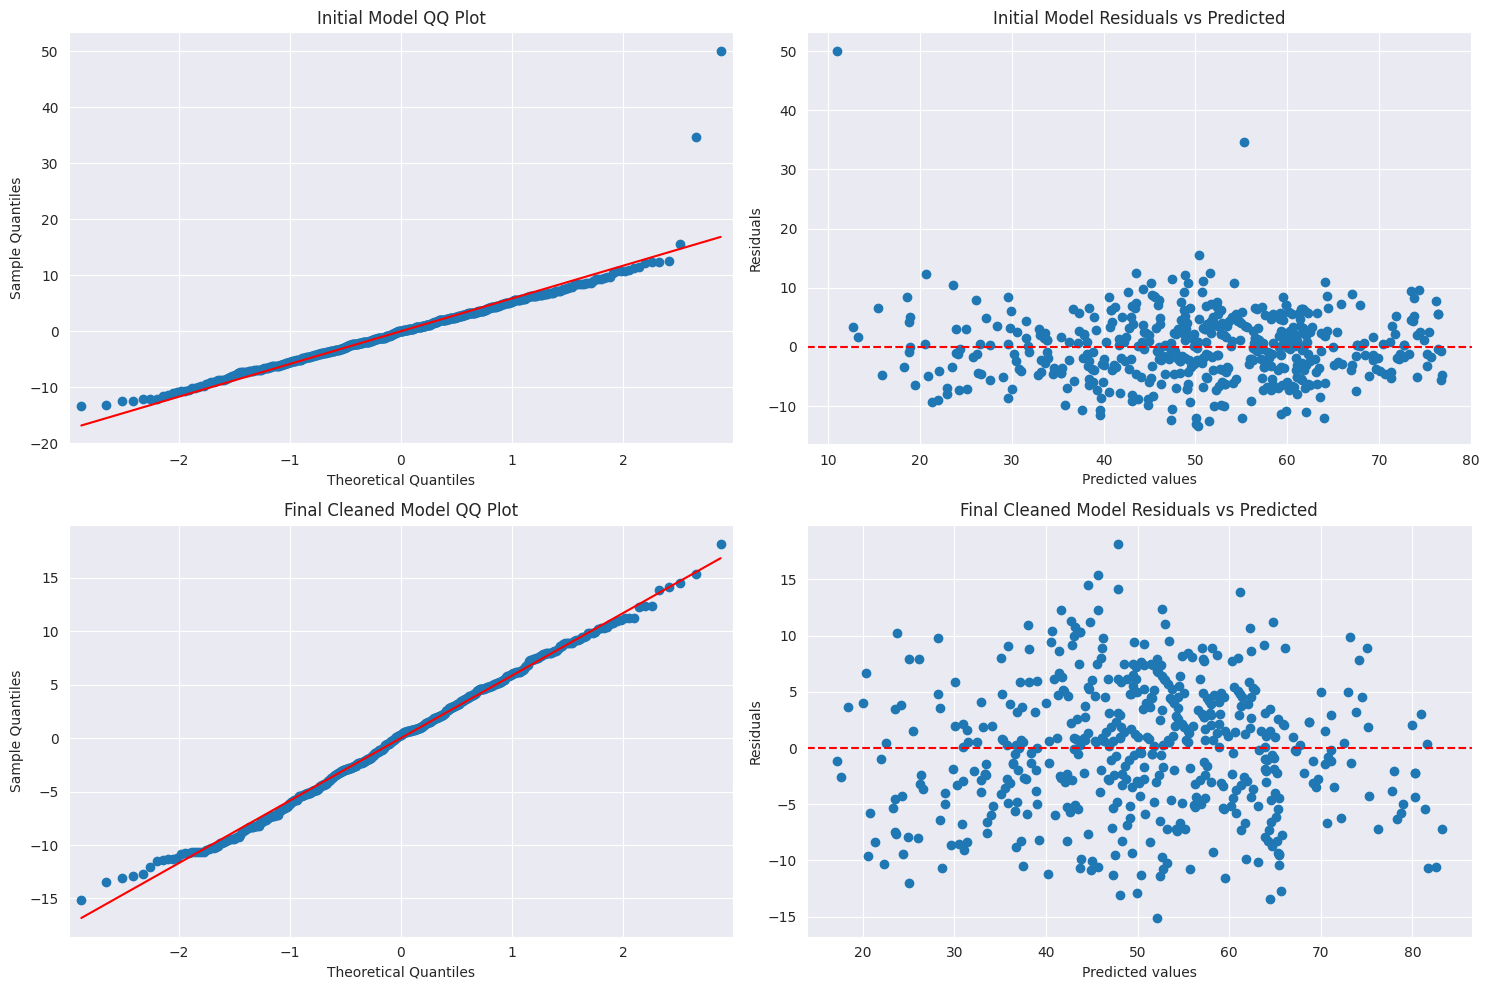

In [40]:
# Set up the matplotlib figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# QQ Plot for the initial model
sm.qqplot(full_model.resid, line='s', ax=axs[0, 0])
axs[0, 0].set_title('Initial Model QQ Plot')

axs[0, 1].scatter(full_model.predict(X_with_constant), full_model.resid)
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_xlabel('Predicted values')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].set_title('Initial Model Residuals vs Predicted')

sm.qqplot(final_model_cleaned.resid, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Final Cleaned Model QQ Plot')

axs[1, 1].scatter(final_model_cleaned.predict(X_cleaned_with_constant), final_model_cleaned.resid)
axs[1, 1].axhline(y=0, color='red', linestyle='--')
axs[1, 1].set_xlabel('Predicted values')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].set_title('Final Cleaned Model Residuals vs Predicted')

plt.tight_layout()
plt.show()


### Výsledný model

Výsledný model je `final_cleaned_model`.  
Rovnice: **Ping [ms] = 8.5942 + 0.0057 * ActiveUsers + 36.6538 * InteractingPct + 8.1826 * OSType_Windows - 0.0035 * ActiveUsers_x_InteractingPct + 0.0017 * ActiveUsers_x_MacOS - 0.0008 * ActiveUsers_x_Windows - 0.0010 * ActiveUsers_x_iOS**



 

### Problematická pozorování
Pro následující pozorování jsme získali největší absolutní rezidua. Zde je vidět, že se jedná o pozorování, která jsou velmi vzdálená od ostatních pozorování. 

In [41]:
# Assuming 'results' is the fitted OLS model from statsmodels
residuals = final_model_cleaned.resid

data['abs_residuals'] = residuals.abs()
problematic_observations = data.sort_values(by='abs_residuals', ascending=False)
problematic_observations.head()


,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms],abs_residuals
82,Windows,4222,0.4858,0.5142,66,18.195429
114,MacOS,4384,0.2231,0.7769,61,15.367582
490,iOS,8839,0.4492,0.5508,37,15.120873
254,iOS,5514,0.5974,0.4026,59,14.472975
228,Android,5037,0.5616,0.4384,62,14.112256


### Odhady pro Windows při průměrných hodnotách ostatních prediktorů

In [42]:
observation = {
    'const': 1,
    'ActiveUsers': np.mean(X_cleaned['ActiveUsers']),
    'InteractingPct': np.mean(X_cleaned['InteractingPct']),
    'OSType_Windows': 1,
    'ActiveUsers_x_InteractingPct': np.mean(X_cleaned['ActiveUsers_x_InteractingPct']),
    'ActiveUsers_x_MacOS': 0,
    'ActiveUsers_x_Windows': np.mean(X_cleaned['ActiveUsers']),
    'ActiveUsers_x_iOS': 0
}

prediction_summary_frame = final_model_cleaned.get_prediction(pd.DataFrame([observation])).summary_frame()

print(f"Predikovaný ping: {prediction_summary_frame['mean'][0]}")
print(f"Konfidenční interval: ({prediction_summary_frame['mean_ci_lower'][0]}; {prediction_summary_frame['mean_ci_upper'][0]})")
print(f"Predikční interval: ({prediction_summary_frame['obs_ci_lower'][0]}; {prediction_summary_frame['obs_ci_upper'][0]})")


Predikovaný ping: 51.75873212745883
Konfidenční interval: (50.75405957403871; 52.76340468087894)
Predikční interval: (40.13747224697249; 63.37999200794516)


### Závěrečné zhodnocení
R-squared a Adjusted R-squared: Hodnoty 0.842 a 0.840 jsou velmi dobré, což naznačuje, že model dobře vysvětluje variabilitu závislé proměnné. Je důležité také zvážit ostatní diagnostické metriky. Vysoká hodnota podmíněného čísla naznačuje problém s kolinearitou atributů, z analýzy VIF hlavně `ActiveUsers_x_InteractingPct`. Pokud bysme však tento odstranili, došlo by ke snížení R-squared a Adjusted R-squared, proto je dobré na tuto možnost upozornit. Dále by stálo za odstranění také `OSType_Windows`, jelikož jako jediný z OSType one-hot kodovaných atributů prošel zpětnou eliminací a vytváří také problém s kolinearitou u atributu `ActiveUsers_x_Windows`. Tyto dva by tedy bylo případně také možné odstranit, pokud to bude stát za snížení R-squared a Adjusted R-squared. Testy Omnibus a Jarque-Bera naznačují, že rezidua nemají významnou odchylku od normálního rozdělení, ale z grafu lze pozorovat, že lehce inklinují doleva a mají lehkou centrální tendenci. Ačkoliv QQ graf pro finální upravený model naznačuje, že rezidua jsou relativně normálně rozdělena, je zde několik bodů, které odchylují od teoretické přímky, což by mohlo signalizovat potenciální odchylky od normálnosti, zejména v krajích distribuce, ale po odstranění odlehlých hodnot je patrné zlepšení :)